# NdLinear - Github

https://github.com/ensemble-core/NdLinear

# Convolutional NdLinear

Research Question
- Does NdLinear have a competitive performance with Convolutional?
- Does combining both technology using addition or concatenation makes the model better?

Methodology
- Prototype using early CNN architecture
- LeNet & AlexNet
- Compare 4 scenarios
  - CNN
  - NdLinear
  - CNN & NdLinear: Addition
  - CNN & NdLinear: Concatenation

In [ ]:
!pip install ndlinear torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attempting

## Import

In [ ]:
import random
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import os
import time
import math
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn

from torchsummary import summary
from torch.utils.data import TensorDataset, Dataset, Subset, DataLoader

from torchvision import transforms

from ndlinear import NdLinear

# MNIST Dataset

Dataset used is MNIST 32x32 dataset, standard small image classification task

In [ ]:
!curl -L -o ./mnist32.zip https://www.kaggle.com/api/v1/datasets/download/sbordt/mnist32

import zipfile
with zipfile.ZipFile("./mnist32.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  680M  100  680M    0     0  35.7M      0  0:00:19  0:00:19 --:--:-- 39.6M


In [ ]:
import pandas as pd

splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["test"])

train_df.iloc[:, 0] = train_df.iloc[:, 0].map(lambda x: x['bytes'])
test_df.iloc[:, 0] = test_df.iloc[:, 0].map(lambda x: x['bytes'])
train_df

,image,label
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,5
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,4
3,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...",1
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,9
...,...,...
59995,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,8
59996,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,3
59997,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,5
59998,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,6


In [ ]:
test_df

,image,label
0,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...",7
1,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...",2
2,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...",1
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,4
...,...,...
9995,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2
9996,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,3
9997,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,4
9998,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,5


## Dataset Class

In [ ]:
class MNIST(Dataset):
  """MNIST Dataset"""

  def __init__(self, csv, transform=None):
    """
      csv_file (pandas DataFrame) : pandas dataframe.
      transform (callable, optional) : Optional transform image
    """
    self.frame = csv
    self.transform = transform

  def __len__(self):
    return len(self.frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    image = self.frame.iloc[idx, 0]

    if isinstance(image, bytes):
      image = np.expand_dims(np.array(Image.open(io.BytesIO(image)), dtype="f")/255, axis=0)
    else:  # If idx is a list, iloc becomes a Series
      image = list(map(lambda x: np.expand_dims(np.array(Image.open(io.BytesIO(x)), dtype="f")/255, axis=0), image))
    image = torch.tensor(image)
    label = self.frame.iloc[idx, 1]
    label = self.onehot(label)

    if self.transform:
      # image.map(self.transform)
      image = self.transform(image)

    sample = (image, label)

    return sample

  def onehot(self, label):
    onehot_label = torch.zeros(10)
    onehot_label[label] = 1

    return onehot_label

In [ ]:
transform = transforms.Compose([
    transforms.Pad(2),
])

In [ ]:
train_dataset = MNIST(train_df, transform)
test_dataset = MNIST(test_df, transform)

In [ ]:
np.unique(train_dataset[:2][0])

/tmp/ipykernel_19/2858281733.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  image = torch.tensor(image)


array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.02352941,
       0.02745098, 0.03529412, 0.03921569, 0.04313726, 0.04705882,
       0.05490196, 0.0627451 , 0.07058824, 0.07450981, 0.08235294,
       0.09019608, 0.09411765, 0.09803922, 0.10196079, 0.10588235,
       0.10980392, 0.11372549, 0.11764706, 0.13725491, 0.14117648,
       0.14509805, 0.14901961, 0.15294118, 0.16862746, 0.1764706 ,
       0.18039216, 0.18431373, 0.1882353 , 0.19215687, 0.19607843,
       0.2       , 0.21176471, 0.21568628, 0.21960784, 0.22352941,
       0.23529412, 0.24705882, 0.2509804 , 0.25882354, 0.27450982,
       0.2784314 , 0.29411766, 0.29803923, 0.30588236, 0.30980393,
       0.3137255 , 0.31764707, 0.32156864, 0.32941177, 0.33333334,
       0.3372549 , 0.3529412 , 0.3647059 , 0.36862746, 0.3764706 ,
       0.41960785, 0.42352942, 0.4392157 , 0.44705883, 0.46666667,
       0.4745098 , 0.47843137, 0.49411765, 0.49803922, 0.5019608 ,
       0.50980395, 0.5137255 , 0.5176471 , 0.52156866, 0.52941

## Split Dataset

In [ ]:
BATCH_SIZE = 32

X_train, X_valid, _, _ = train_test_split(np.arange(len(train_df)), train_df['label'], test_size=0.10, random_state=42, stratify=train_df['label'])

valid_dataset = Subset(train_dataset, X_valid)
train_dataset = Subset(train_dataset, X_train)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# LeNet-1

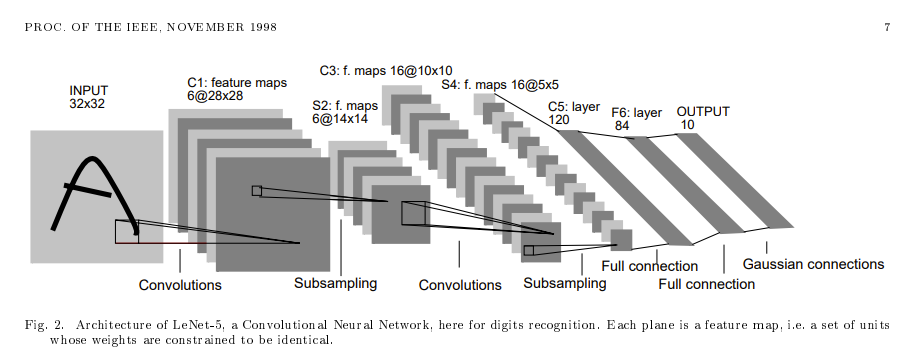

Layers
- 32x32x1 : Input Grayscale Image
- 28x28x6 : (5x5) CNN
- 14x14x6 : (2x2) Average Pooling
- 10x10x16: (5x5) CNN
- 5x5x16  : (2x2) Average Pooling
- 120x1   : (400x120) Flatten
- 84x1    : (120x84) Flatten
- 10x1    : (10x1) Flatten

## Model definition

In [ ]:
class LeNetAllCNN(nn.Module):
    def __init__(self, input_size = 1, output_size = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(input_size, 6, kernel_size=(5, 5), padding=(0, 0))
        self.pool1 = nn.AvgPool2d((2, 2))

        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), padding=(0, 0))
        self.pool2 = nn.AvgPool2d((2, 2))

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool2(x)

        return x

In [ ]:
class LeNetAllNdLinear(nn.Module):
    def __init__(self, input_size = 1, output_size = 10):
        super().__init__()

        self.ndl1 = NdLinear(input_dims=(input_size, 32, 32), hidden_size=(6, 28, 28))
        self.pool1 = nn.AvgPool2d((2, 2))

        self.ndl2 = NdLinear(input_dims=(6, 14, 14), hidden_size=(16, 10, 10))
        self.pool2 = nn.AvgPool2d((2, 2))

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.ndl1(x)
        x = self.tanh(x)
        x = self.pool1(x)

        x = self.ndl2(x)
        x = self.tanh(x)
        x = self.pool2(x)

        return x

In [ ]:
class LeNetAddition(nn.Module):
    def __init__(self, input_size = 1, output_size = 10):
        super().__init__()

        self.ndl1 = NdLinear(input_dims=(input_size, 32, 32), hidden_size=(6, 28, 28))
        self.conv1 = nn.Conv2d(input_size, 6, kernel_size=(5, 5), padding=(0, 0))
        self.pool1 = nn.AvgPool2d((2, 2))

        self.ndl2 = NdLinear(input_dims=(6, 14, 14), hidden_size=(16, 10, 10))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), padding=(0, 0))
        self.pool2 = nn.AvgPool2d((2, 2))

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.ndl1(x) + self.conv1(x)
        x = self.tanh(x)
        x = self.pool1(x)

        x = self.ndl2(x) + self.conv2(x)
        x = self.tanh(x)
        x = self.pool2(x)

        return x

In [ ]:
class LeNetConcatenation(nn.Module):
    def __init__(self, input_size = 1, output_size = 10):
        super().__init__()

        self.ndl1 = NdLinear(input_dims=(input_size, 32, 32), hidden_size=(3, 28, 28))
        self.conv1 = nn.Conv2d(input_size, 3, kernel_size=(5, 5), padding=(0, 0))
        self.pool1 = nn.AvgPool2d((2, 2))

        self.ndl2 = NdLinear(input_dims=(6, 14, 14), hidden_size=(8, 10, 10))
        self.conv2 = nn.Conv2d(6, 8, kernel_size=(5, 5), padding=(0, 0))
        self.pool2 = nn.AvgPool2d((2, 2))

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = torch.cat((self.ndl1(x), self.conv1(x)), 1)
        x = self.tanh(x)
        x = self.pool1(x)

        x = torch.cat((self.ndl2(x), self.conv2(x)), 1)
        x = self.tanh(x)
        x = self.pool2(x)

        return x

### MLP Head

In [ ]:
class LeNetMLPHead(nn.Module):
    def __init__(self, model, input_size=400, output_size=10):
        super().__init__()
        self.input_size = input_size

        self.model = model

        self.fc1 = nn.Linear(input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

## Model Evaluation

### All CNN

In [ ]:
summary(LeNetAllCNN(), input_size=(1, 32, 32), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
Total params: 2,572
Trainable params: 2,572
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.01
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


### All NdLinear

In [ ]:
summary(LeNetAllNdLinear(), (1, 32, 32), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 6]              12
            Linear-2                   [-1, 28]             924
            Linear-3                   [-1, 28]             924
          NdLinear-4            [-1, 6, 28, 28]               0
              Tanh-5            [-1, 6, 28, 28]               0
         AvgPool2d-6            [-1, 6, 14, 14]               0
            Linear-7                   [-1, 16]             112
            Linear-8                   [-1, 10]             150
            Linear-9                   [-1, 10]             150
         NdLinear-10           [-1, 16, 10, 10]               0
             Tanh-11           [-1, 16, 10, 10]               0
        AvgPool2d-12             [-1, 16, 5, 5]               0
Total params: 2,272
Trainable params: 2,272
Non-trainable params: 0
-----------------------------------

### Addition

In [ ]:
summary(LeNetAddition(), (1, 32, 32), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 6]              12
            Linear-2                   [-1, 28]             924
            Linear-3                   [-1, 28]             924
          NdLinear-4            [-1, 6, 28, 28]               0
            Conv2d-5            [-1, 6, 28, 28]             156
              Tanh-6            [-1, 6, 28, 28]               0
         AvgPool2d-7            [-1, 6, 14, 14]               0
            Linear-8                   [-1, 16]             112
            Linear-9                   [-1, 10]             150
           Linear-10                   [-1, 10]             150
         NdLinear-11           [-1, 16, 10, 10]               0
           Conv2d-12           [-1, 16, 10, 10]           2,416
             Tanh-13           [-1, 16, 10, 10]               0
        AvgPool2d-14             [-1, 1

### Concatenation

In [ ]:
summary(LeNetConcatenation(), (1, 32, 32), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               6
            Linear-2                   [-1, 28]             924
            Linear-3                   [-1, 28]             924
          NdLinear-4            [-1, 3, 28, 28]               0
            Conv2d-5            [-1, 3, 28, 28]              78
              Tanh-6            [-1, 6, 28, 28]               0
         AvgPool2d-7            [-1, 6, 14, 14]               0
            Linear-8                    [-1, 8]              56
            Linear-9                   [-1, 10]             150
           Linear-10                   [-1, 10]             150
         NdLinear-11            [-1, 8, 10, 10]               0
           Conv2d-12            [-1, 8, 10, 10]           1,208
             Tanh-13           [-1, 16, 10, 10]               0
        AvgPool2d-14             [-1, 1

## Loss function

In [ ]:
loss_func = nn.CrossEntropyLoss()

## Early Stopping

> Source: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

## Training

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 5e-5
EPOCH = 30

model_list = [LeNetMLPHead(LeNetAllCNN()), LeNetMLPHead(LeNetAllNdLinear()), LeNetMLPHead(LeNetAddition()), LeNetMLPHead(LeNetConcatenation())]
training_loss = []
validation_loss = []

for model in model_list:
  model.to(DEVICE)
  model_train_loss = []
  model_valid_loss = []
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)
  es = EarlyStopping(patience=5)
  start_time = time.time()
  for epoch_i in tqdm(range(0, EPOCH)):
    epoch_train_loss = 0
    epoch_valid_loss = 0

    model.train()
    for data in train_dataloader:
      image, label = data
      image = image.to(DEVICE)
      label = label.to(DEVICE)

      pred = model(image)

      loss = loss_func(pred, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_train_loss += loss.item()

    model.eval()
    for data in valid_dataloader:
      with torch.no_grad():

        image, label = data
        image = image.to(DEVICE)
        label = label.to(DEVICE)

        pred = model(image)

        loss = loss_func(pred, label)

        epoch_valid_loss += loss.item()


    # print(f"Training Loss: {epoch_train_loss / math.ceil(len(train_dataset) / BATCH_SIZE)}")
    # print(f"Validation Loss: {epoch_valid_loss / math.ceil(len(valid_dataset) / BATCH_SIZE)}")

    model_train_loss.append(epoch_train_loss / math.ceil(len(train_dataset) / BATCH_SIZE))
    model_valid_loss.append(epoch_valid_loss / math.ceil(len(valid_dataset) / BATCH_SIZE))

    if es.step(torch.tensor(epoch_valid_loss / math.ceil(len(valid_dataset) / BATCH_SIZE))):
        break  # early stop criterion is met, we can stop now

  training_loss.append(model_train_loss)
  validation_loss.append(model_valid_loss)

  print("")
  print(f"Training {model.model.__class__.__name__} Finished!")
  print(f"Training time: {time.time() - start_time}")
  print("")

100%|██████████| 30/30 [10:43<00:00, 21.44s/it]



Training LeNetAllCNN Finished!
Training time: 643.2802538871765



100%|██████████| 30/30 [11:36<00:00, 23.22s/it]



Training LeNetAllNdLinear Finished!
Training time: 696.5051956176758



100%|██████████| 30/30 [12:02<00:00, 24.10s/it]



Training LeNetAddition Finished!
Training time: 722.9390325546265



100%|██████████| 30/30 [12:06<00:00, 24.23s/it]


Training LeNetConcatenation Finished!
Training time: 726.7796497344971



## Loss Visualization

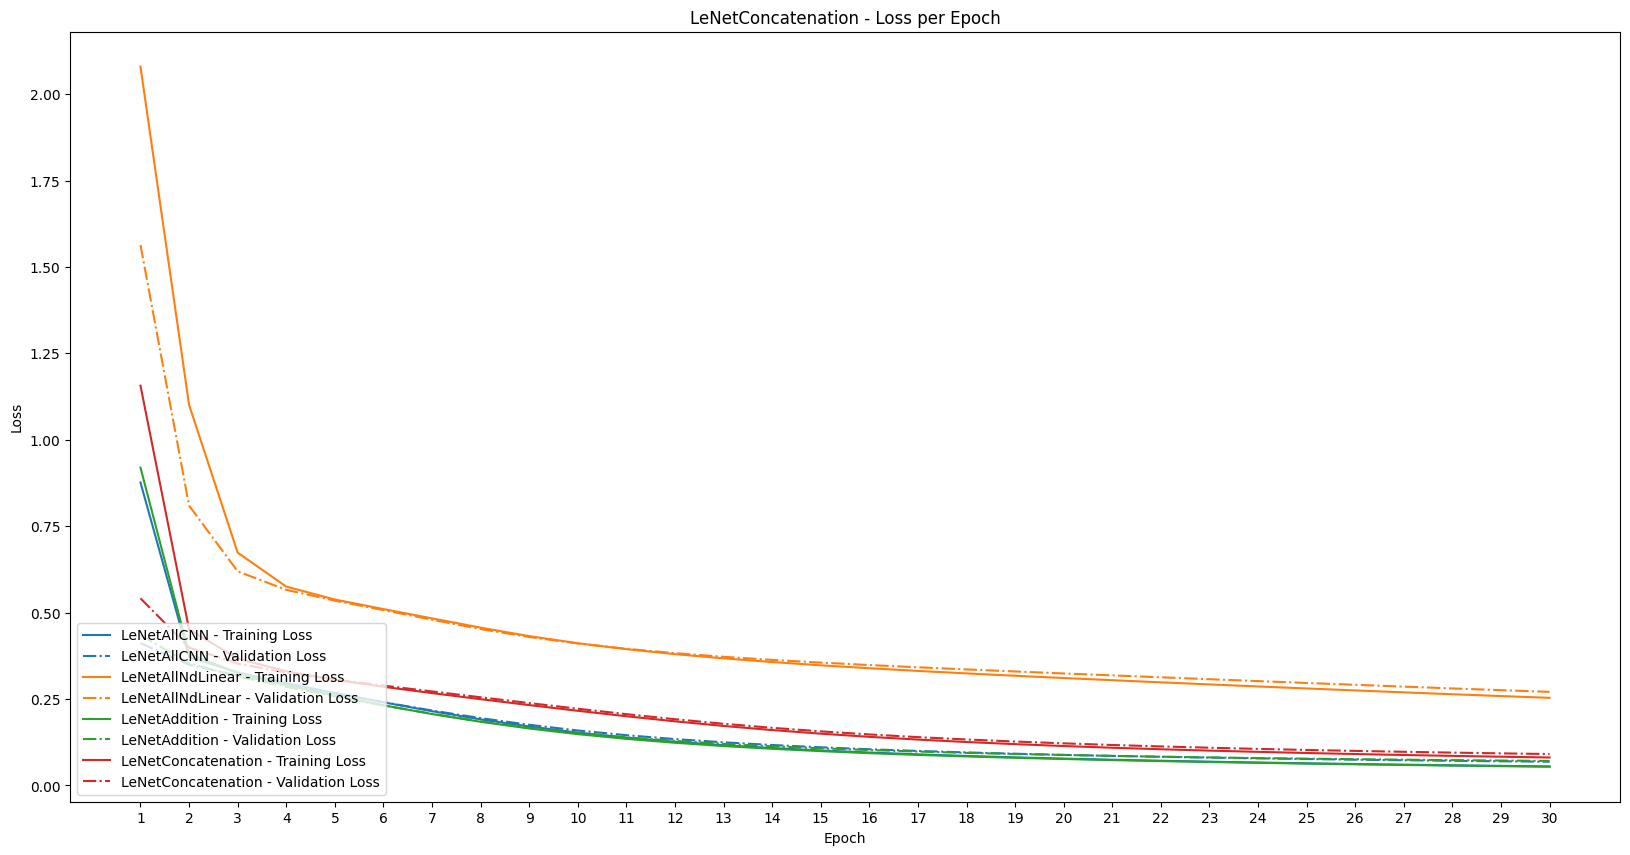

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
legend = []
plt.figure(figsize=(20,10))
for i in range(len(model_list)):
  x = np.arange(1, len(training_loss[i]) + 1)
  y_train_loss = np.asarray(training_loss[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_loss[i], dtype=np.float32)



  plt.plot(x, y_train_loss[0:EPOCH], color=colors[i])
  plt.plot(x, y_val_loss[0:EPOCH], '-.', color=colors[i])

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  legend.extend([f"{model_list[i].model.__class__.__name__} - Training Loss", f"{model_list[i].model.__class__.__name__} - Validation Loss"])

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'{model_list[i].model.__class__.__name__} - Loss per Epoch')
plt.legend(legend, loc="lower left")
plt.show()

## Testing

In [ ]:
precision = []
recall = []
f1 = []
for model in model_list:
  model.to(DEVICE)
  model_label = []
  model_pred = []
  for data in test_dataloader:
    image, label = data
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    pred = model(image)

    model_label.extend(label)
    model_pred.extend(pred)
  model_label = torch.stack(model_label)
  model_pred = torch.stack(model_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(torch.argmax(model_label.detach().cpu(), dim=-1), torch.argmax(model_pred.detach().cpu(), dim=-1), average='macro')
  precision.append(model_precision)
  recall.append(model_recall)
  f1.append(model_f1)

pd.DataFrame({"Model": [model.model.__class__.__name__ for model in model_list],
              "Precision": precision,
              "Recall": recall,
              "F1": f1})

,Model,Precision,Recall,F1
0,LeNetAllCNN,0.983228,0.983200,0.983195
1,LeNetAllNdLinear,0.926775,0.926337,0.926431
2,LeNetAddition,0.981737,0.981763,0.981734
3,LeNetConcatenation,0.976824,0.977031,0.976904


In [ ]:
print(model_label[:2])
print(model_pred[:2])

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[ -3.4198,  -6.4377,   2.4513,   6.6129,  -4.7606,  -1.6262, -19.7481,
          15.2235,  -1.5420,   1.4521],
        [  3.7992,   5.4664,  13.9590,   5.1357, -13.4740,  -3.9859,   1.6550,
          -5.9824,   3.4457, -10.2957]], device='cuda:0',
       grad_fn=<SliceBackward0>)


## Save Experiment Data

In [ ]:
import pickle

# Saving the objects:
with open('lenet-training-loss.pkl', 'wb') as f:
    pickle.dump(training_loss, f)

with open('lenet-validation-loss.pkl', 'wb') as f:
    pickle.dump(validation_loss, f)

pd.DataFrame({"Model": [model.model.__class__.__name__ for model in model_list],
              "Precision": precision,
              "Recall": recall,
              "F1": f1}).to_csv("lenet-metrics.csv")

# Imagenette Dataset

Dataset used is imagenette 224x224 dataset, subset dataset from ImageNet

Source
> https://github.com/fastai/imagenette

Reason of choosing
- AlexNET is trained on ImageNet
- ImageNet is too large for prototyping (Free tier Google Colab), use imagenette instead

Additional Information on Imagenette
- Imagenette provides noisy label, but for the sake of clarity and ablation study, uses the normal label

In [ ]:
!curl -L -o ./imagenette.tgz https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

!tar -xvzf ./imagenette.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1485M  100 1485M    0     0  2954k      0  0:08:34  0:08:34 --:--:-- 2869k
imagenette2/
imagenette2/train/
imagenette2/noisy_imagenette.csv
imagenette2/val/
imagenette2/val/n03394916/
imagenette2/val/n03417042/
imagenette2/val/n03445777/
imagenette2/val/n02102040/
imagenette2/val/n03425413/
imagenette2/val/n03888257/
imagenette2/val/n03028079/
imagenette2/val/n03000684/
imagenette2/val/n01440764/
imagenette2/val/n02979186/
imagenette2/val/n02979186/n02979186_7492.JPEG
imagenette2/val/n02979186/n02979186_491.JPEG
imagenette2/val/n02979186/n02979186_24591.JPEG
imagenette2/val/n02979186/n02979186_26451.JPEG
imagenette2/val/n02979186/n02979186_11372.JPEG
imagenette2/val/n02979186/n02979186_1792.JPEG
imagenette2/val/n02979186/n02979186_22111.JPEG
imagenette2/val/n02979186/n02979186_18450.JPEG
imagenette2/val/n02979186/n02979186_200

In [ ]:
label_imagenette = pd.read_csv("imagenette2/noisy_imagenette.csv")
train_imagenette = label_imagenette[label_imagenette['is_valid'] == False].iloc[:, :2].reset_index(drop=True)  # Column 1 is path, Column 2 is normal label
test_imagenette = label_imagenette[label_imagenette['is_valid'] == True].iloc[:, :2].reset_index(drop=True)
train_imagenette

,path,noisy_labels_0
0,train/n02979186/n02979186_9036.JPEG,n02979186
1,train/n02979186/n02979186_11957.JPEG,n02979186
2,train/n02979186/n02979186_9715.JPEG,n02979186
3,train/n02979186/n02979186_21736.JPEG,n02979186
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186
...,...,...
9464,train/n03425413/n03425413_6695.JPEG,n03425413
9465,train/n03425413/n03425413_7283.JPEG,n03425413
9466,train/n03425413/n03425413_13096.JPEG,n03425413
9467,train/n03425413/n03425413_444.JPEG,n03425413


In [ ]:
test_imagenette

,path,noisy_labels_0
0,val/n02979186/n02979186_8971.JPEG,n02979186
1,val/n02979186/n02979186_14550.JPEG,n02979186
2,val/n02979186/n02979186_11971.JPEG,n02979186
3,val/n02979186/n02979186_11550.JPEG,n02979186
4,val/n02979186/n02979186_8751.JPEG,n02979186
...,...,...
3920,val/n03425413/n03425413_17521.JPEG,n03425413
3921,val/n03425413/n03425413_20711.JPEG,n03425413
3922,val/n03425413/n03425413_19050.JPEG,n03425413
3923,val/n03425413/n03425413_13831.JPEG,n03425413


In [ ]:
np.unique(label_imagenette['noisy_labels_0'])

array(['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079',
       'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257'],
      dtype=object)

> Check grayscale image in colored dataset, decided whether to drop or keep

In [ ]:
gray_image = []
for i, a in enumerate([np.array(Image.open('imagenette2/' + train_imagenette.iloc[i, 0])).shape for i in range(len(train_imagenette))]):
  if len(a) < 3:
    gray_image.append(i)

print("")
print(f"Gray Image total: {len(gray_image)}")
print(f"Image total: {len(train_imagenette)}")


Gray Image total: 173
Image total: 9469


In [ ]:
gray_image_test = []
for i, a in enumerate([np.array(Image.open('imagenette2/' + test_imagenette.iloc[i, 0])).shape for i in range(len(test_imagenette))]):
  if len(a) < 3:
    gray_image_test.append(i)

print("")
print(f"Gray Image total: {len(gray_image_test)}")
print(f"Image total: {len(test_imagenette)}")


Gray Image total: 69
Image total: 3925


> Drop the grayscale image

In [ ]:
train_imagenette = train_imagenette.drop(gray_image).reset_index(drop=True)

In [ ]:
test_imagenette = test_imagenette.drop(gray_image_test).reset_index(drop=True)

> Check the distributions of images shape

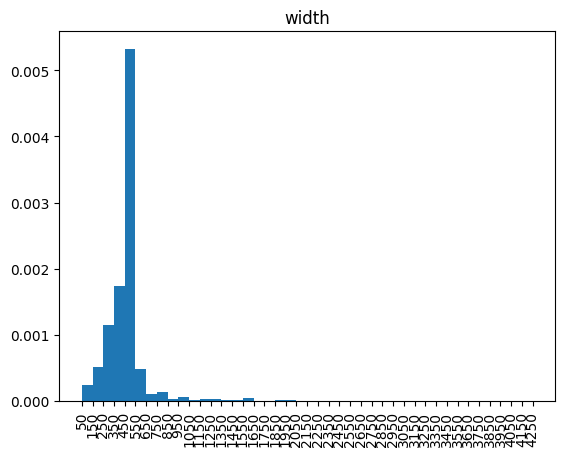

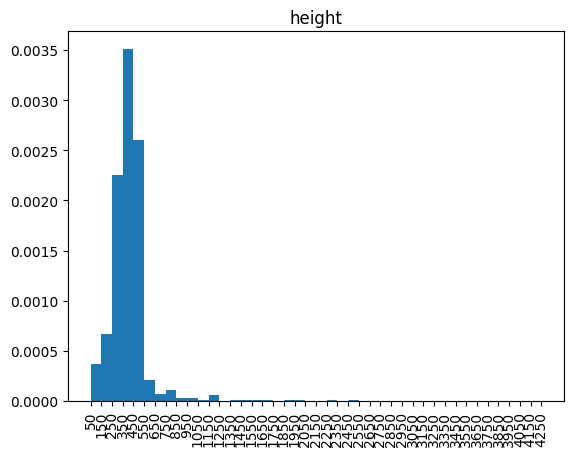

In [ ]:
sizes = [(width, height) for width, height in [Image.open('imagenette2/' + train_imagenette.iloc[i, 0]).size for i in range(len(train_imagenette))]]
width = [sizes[i][0] for i in range(len(sizes))]
height = [sizes[i][1] for i in range(len(sizes))]
bins = np.arange(min(width), max(width)+1, 100)

plt.hist(width, density=True, bins=bins)
plt.title("width")
plt.xticks(bins, rotation=90)
plt.show()
plt.hist(height, density=True, bins=bins)
plt.title("height")
plt.xticks(bins, rotation=90)
plt.show()

del sizes
del width
del height
del bins

(500, 333)


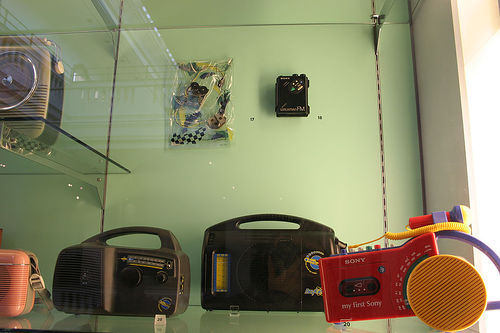

In [ ]:
print(Image.open('imagenette2/' + train_imagenette.iloc[1, 0]).size)
Image.open('imagenette2/' + train_imagenette.iloc[1, 0])

(500, 375)


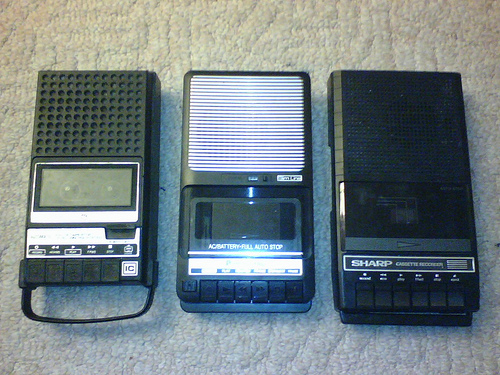

In [ ]:
print(Image.open('imagenette2/' + test_imagenette.iloc[1, 0]).size)
Image.open('imagenette2/' + test_imagenette.iloc[1, 0])

## Dataset Class

In [ ]:
class ImageNette(Dataset):
  """ImageNette Dataset"""

  def __init__(self, csv, root_dir, transform=None):
    """
      csv_file (pandas DataFrame) : pandas dataframe.
      root_dir (string) : root dir for the images.
      transform (callable, optional) : Optional transform image
    """
    self.frame = csv
    self.root_dir = root_dir
    self.transform = transform

    self.label2id = {"n01440764": 0, "n02102040": 1, "n02979186": 2, "n03000684": 3, "n03028079": 4,
                     "n03394916": 5, "n03417042": 6, "n03425413": 7, "n03445777": 8, "n03888257": 9}
    self.id2label = {0: "n01440764", 1: "n02102040", 2: "n02979186", 3: "n03000684", 4: "n03028079",
                     5: "n03394916", 6: "n03417042", 7: "n03425413", 8: "n03445777", 9: "n03888257"}

  def __len__(self):
    return len(self.frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    image = self.frame.iloc[idx, 0]

    if isinstance(image, type(pd.Series())):
      image_path = [os.path.join(self.root_dir, path) for path in self.frame.iloc[idx, 0]]
      image = [Image.open(path) for path in image_path]
      if self.transform:
        image = np.expand_dims([self.transform(i) for i in image], axis=0)
      image = torch.tensor(image)
      label = self.frame.iloc[idx, 1]
      label = torch.stack([self.onehot(l) for l in label])
    else:  # If idx is a list, iloc becomes a Series
      image_path = os.path.join(self.root_dir, self.frame.iloc[idx, 0])
      image = Image.open(image_path)
      if self.transform:
        image = self.transform(image)
      label = self.frame.iloc[idx, 1]
      label = self.onehot(label)

    sample = (image, label)

    return sample

  def onehot(self, label):
    onehot_label = torch.zeros(len(self.label2id))
    onehot_label[self.label2id[label]] = 1

    return onehot_label

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop((320, 320)),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = ImageNette(train_imagenette, 'imagenette2', transform)
test_dataset = ImageNette(test_imagenette, 'imagenette2', transform)

In [ ]:
train_dataset[0][1]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

## Split Dataset

In [ ]:
BATCH_SIZE = 32

X_train, X_valid, _, _ = train_test_split(np.arange(len(train_imagenette)), train_imagenette['noisy_labels_0'], test_size=0.10, random_state=42, stratify=train_imagenette['noisy_labels_0'])

valid_dataset = Subset(train_dataset, X_valid)
train_dataset = Subset(train_dataset, X_train)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# AlexNet

## Disclaimer

> Because the actual ImageNet is huge, for prototyping, use Tiny ImageNet
>
> https://www.kaggle.com/c/tiny-imagenet

> The architecture of AlexNet modified only on the first (CNN and Pool) layers to correspond with the tiny image size. Only modfiy the MLP Head parts

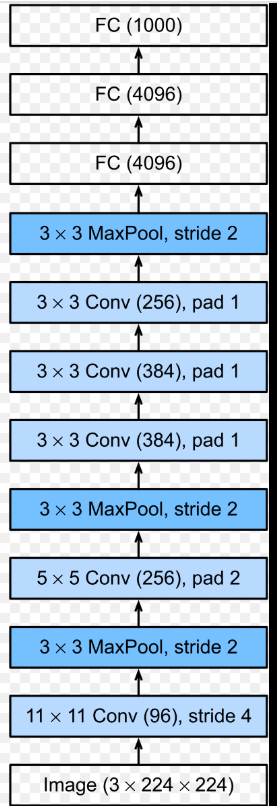

Original AlexNet

Source - [Wikipedia](https://en.wikipedia.org/wiki/AlexNet#/media/File:AlexNet_block_diagram.svg)

Layers
- 224x224x3: Input Colored Image
- 54x54x96 : (11x11, Stride 4) CNN
- 26x26x96 : (3x3, Stride 2) Max Pooling
- 26x26x256: (5x5, Pad 2) CNN
- 12x12x256: (3x3, Stride 2) Max Pooling
- 12x12x384: (3x3, Pad 1) CNN
- 12x12x384: (3x3, Pad 1) CNN
- 12x12x256: (3x3, Pad 1) CNN
- 5x5x256  : (3x3, Stride 2) Max Pooling
- 4096x1   : (6400x4096) Linear
- 4096x1   : (4096x4096) Linear
- 1000x1   : (4096x1000) Linear

## Model definition

In [ ]:
class AlexNetAllCNN(nn.Module):
    def __init__(self, input_size = 3, output_size = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(input_size, 96, kernel_size=(11, 11), stride=(4, 4))
        self.pool1 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.conv2 = nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2, 2))
        self.pool2 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.conv3_1 = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1, 1))
        self.conv3_2 = nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1, 1))
        self.conv3_3 = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.relu(x)
        x = self.pool3(x)

        return x

In [ ]:
class AlexNetAllNdLinear(nn.Module):
    def __init__(self, input_size = 3, output_size = 10):
        super().__init__()

        self.ndlinear1 = NdLinear(input_dims=(input_size, 224, 224), hidden_size=(96, 54, 54))
        self.pool1 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.ndlinear2 = NdLinear(input_dims=(96, 26, 26), hidden_size=(256, 26, 26))
        self.pool2 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.ndlinear3_1 = NdLinear(input_dims=(256, 12, 12), hidden_size=(384, 12, 12))
        self.ndlinear3_2 = NdLinear(input_dims=(384, 12, 12), hidden_size=(384, 12, 12))
        self.ndlinear3_3 = NdLinear(input_dims=(384, 12, 12), hidden_size=(256, 12, 12))
        self.pool3 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.ndlinear1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.ndlinear2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.ndlinear3_1(x)
        x = self.ndlinear3_2(x)
        x = self.ndlinear3_3(x)
        x = self.relu(x)
        x = self.pool3(x)

        return x

In [ ]:
class AlexNetAddition(nn.Module):
    def __init__(self, input_size = 3, output_size = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(input_size, 96, kernel_size=(11, 11), stride=(4, 4))
        self.ndlinear1 = NdLinear(input_dims=(input_size, 224, 224), hidden_size=(96, 54, 54))
        self.pool1 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.conv2 = nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2, 2))
        self.ndlinear2 = NdLinear(input_dims=(96, 26, 26), hidden_size=(256, 26, 26))
        self.pool2 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.conv3_1 = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1, 1))
        self.conv3_2 = nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1, 1))
        self.conv3_3 = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1, 1))
        self.ndlinear3_1 = NdLinear(input_dims=(256, 12, 12), hidden_size=(384, 12, 12))
        self.ndlinear3_2 = NdLinear(input_dims=(384, 12, 12), hidden_size=(384, 12, 12))
        self.ndlinear3_3 = NdLinear(input_dims=(384, 12, 12), hidden_size=(256, 12, 12))
        self.pool3 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.ndlinear1(x) + self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.ndlinear2(x) + self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.ndlinear3_1(x) + self.conv3_1(x)
        x = self.ndlinear3_2(x) + self.conv3_2(x)
        x = self.ndlinear3_3(x) + self.conv3_3(x)
        x = self.relu(x)
        x = self.pool2(x)

        return x

In [ ]:
class AlexNetConcatenation(nn.Module):
    def __init__(self, input_size = 3, output_size = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(input_size, 48, kernel_size=(11, 11), stride=(4, 4))
        self.ndlinear1 = NdLinear(input_dims=(input_size, 224, 224), hidden_size=(48, 54, 54))
        self.pool1 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.conv2 = nn.Conv2d(96, 128, kernel_size=(5, 5), padding=(2, 2))
        self.ndlinear2 = NdLinear(input_dims=(96, 26, 26), hidden_size=(128, 26, 26))
        self.pool2 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.conv3_1 = nn.Conv2d(256, 192, kernel_size=(3, 3), padding=(1, 1))
        self.conv3_2 = nn.Conv2d(384, 192, kernel_size=(3, 3), padding=(1, 1))
        self.conv3_3 = nn.Conv2d(384, 128, kernel_size=(3, 3), padding=(1, 1))
        self.ndlinear3_1 = NdLinear(input_dims=(256, 12, 12), hidden_size=(192, 12, 12))
        self.ndlinear3_2 = NdLinear(input_dims=(384, 12, 12), hidden_size=(192, 12, 12))
        self.ndlinear3_3 = NdLinear(input_dims=(384, 12, 12), hidden_size=(128, 12, 12))
        self.pool3 = nn.MaxPool2d((3, 3), stride=(2, 2))

        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.cat((self.ndlinear1(x), self.conv1(x)), 1)
        x = self.relu(x)
        x = self.pool1(x)

        x = torch.cat((self.ndlinear2(x), self.conv2(x)), 1)
        x = self.relu(x)
        x = self.pool2(x)

        x = torch.cat((self.ndlinear3_1(x), self.conv3_1(x)), 1)
        x = torch.cat((self.ndlinear3_2(x), self.conv3_2(x)), 1)
        x = torch.cat((self.ndlinear3_3(x), self.conv3_3(x)), 1)
        x = self.relu(x)
        x = self.pool2(x)

        return x

### MLP Head

In [ ]:
class AlexNetMLPHead(nn.Module):
    def __init__(self, model, input_size=6400, output_size=10):
        super().__init__()
        self.input_size = input_size

        self.model = model

        self.fc1 = nn.Linear(input_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, output_size)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

## Model Evaluation

### All CNN

In [ ]:
summary(AlexNetAllCNN(), input_size=(3, 224, 224), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6          [-1, 256, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         885,120
            Conv2d-8          [-1, 384, 12, 12]       1,327,488
            Conv2d-9          [-1, 256, 12, 12]         884,992
             ReLU-10          [-1, 256, 12, 12]               0
        MaxPool2d-11            [-1, 256, 5, 5]               0
Total params: 3,747,200
Trainable params: 3,747,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forw

### All NdLinear

In [ ]:
summary(AlexNetAllNdLinear(), input_size=(3, 224, 224), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 96]             384
            Linear-2                   [-1, 54]          12,150
            Linear-3                   [-1, 54]          12,150
          NdLinear-4           [-1, 96, 54, 54]               0
              ReLU-5           [-1, 96, 54, 54]               0
         MaxPool2d-6           [-1, 96, 26, 26]               0
            Linear-7                  [-1, 256]          24,832
            Linear-8                   [-1, 26]             702
            Linear-9                   [-1, 26]             702
         NdLinear-10          [-1, 256, 26, 26]               0
             ReLU-11          [-1, 256, 26, 26]               0
        MaxPool2d-12          [-1, 256, 12, 12]               0
           Linear-13                  [-1, 384]          98,688
           Linear-14                   

### Addition

In [ ]:
summary(AlexNetAddition(), input_size=(3, 224, 224), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 96]             384
            Linear-2                   [-1, 54]          12,150
            Linear-3                   [-1, 54]          12,150
          NdLinear-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]          34,944
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Linear-8                  [-1, 256]          24,832
            Linear-9                   [-1, 26]             702
           Linear-10                   [-1, 26]             702
         NdLinear-11          [-1, 256, 26, 26]               0
           Conv2d-12          [-1, 256, 26, 26]         614,656
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

### Concatenation

In [ ]:
summary(AlexNetConcatenation(), input_size=(3, 224, 224), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 48]             192
            Linear-2                   [-1, 54]          12,150
            Linear-3                   [-1, 54]          12,150
          NdLinear-4           [-1, 48, 54, 54]               0
            Conv2d-5           [-1, 48, 54, 54]          17,472
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Linear-8                  [-1, 128]          12,416
            Linear-9                   [-1, 26]             702
           Linear-10                   [-1, 26]             702
         NdLinear-11          [-1, 128, 26, 26]               0
           Conv2d-12          [-1, 128, 26, 26]         307,328
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

## Loss function

In [ ]:
loss_func = nn.CrossEntropyLoss()

## Early Stopping

> Source: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

## Training

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 5e-5
EPOCH = 30

model_list = [AlexNetMLPHead(AlexNetAllCNN()), AlexNetMLPHead(AlexNetAllNdLinear()), AlexNetMLPHead(AlexNetAddition()), AlexNetMLPHead(AlexNetConcatenation())]
training_loss = []
validation_loss = []

for model in model_list:
  model.to(DEVICE)
  model_train_loss = []
  model_valid_loss = []
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)
  es = EarlyStopping(patience = 5)
  start_time = time.time()
  for epoch_i in tqdm(range(0, EPOCH)):
    epoch_train_loss = 0
    epoch_valid_loss = 0

    model.train()
    for data in train_dataloader:
      image, label = data
      image = image.to(DEVICE)
      label = label.to(DEVICE)

      pred = model(image)

      loss = loss_func(pred, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_train_loss += loss.item()

    model.eval()
    for data in valid_dataloader:
      with torch.no_grad():

        image, label = data
        image = image.to(DEVICE)
        label = label.to(DEVICE)

        pred = model(image)

        loss = loss_func(pred, label)

        epoch_valid_loss += loss.item()

    # print(f"Training Loss: {epoch_train_loss / math.ceil(len(train_dataset) / BATCH_SIZE)}")
    # print(f"Validation Loss: {epoch_valid_loss / math.ceil(len(valid_dataset) / BATCH_SIZE)}")

    model_train_loss.append(epoch_train_loss / math.ceil(len(train_dataset) / BATCH_SIZE))
    model_valid_loss.append(epoch_valid_loss / math.ceil(len(valid_dataset) / BATCH_SIZE))

    if es.step(torch.tensor(epoch_valid_loss / math.ceil(len(valid_dataset) / BATCH_SIZE))):
        break

  training_loss.append(model_train_loss)
  validation_loss.append(model_valid_loss)

  model.to("cpu")

  print("")
  print(f"Training {model.model.__class__.__name__} Finished!")
  print(f"Training time: {time.time() - start_time}")
  print("")

 30%|███       | 9/30 [07:59<18:38, 53.28s/it]



Training AlexNetAllCNN Finished!
Training time: 479.8598840236664



100%|██████████| 30/30 [32:05<00:00, 64.19s/it]



Training AlexNetAllNdLinear Finished!
Training time: 1926.1642701625824



 47%|████▋     | 14/30 [17:02<19:29, 73.07s/it]



Training AlexNetAddition Finished!
Training time: 1023.2825741767883



 53%|█████▎    | 16/30 [16:23<14:20, 61.46s/it]



Training AlexNetConcatenation Finished!
Training time: 983.6663887500763



## Loss Visualization

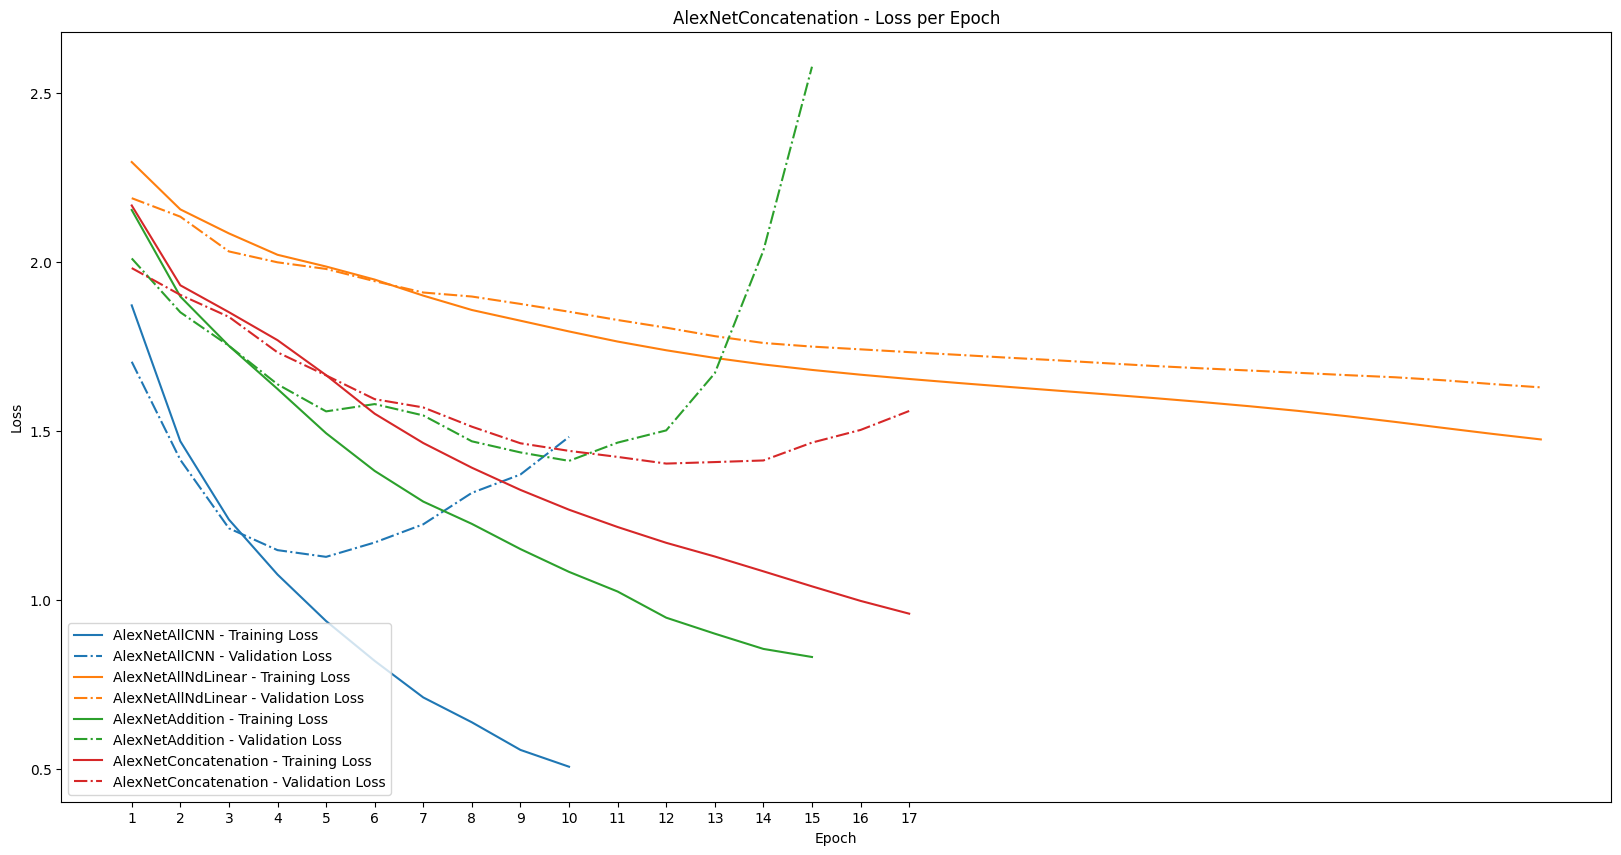

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
legend = []
plt.figure(figsize=(20,10))
for i in range(len(model_list)):
  x = np.arange(1, len(training_loss[i]) + 1)
  y_train_loss = np.asarray(training_loss[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_loss[i], dtype=np.float32)

  plt.plot(x, y_train_loss[0:EPOCH], color=colors[i])
  plt.plot(x, y_val_loss[0:EPOCH], '-.', color=colors[i])

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  legend.extend([f"{model_list[i].model.__class__.__name__} - Training Loss", f"{model_list[i].model.__class__.__name__} - Validation Loss"])

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'{model_list[i].model.__class__.__name__} - Loss per Epoch')
plt.legend(legend, loc="lower left")
plt.show()

## Testing

In [ ]:
precision = []
recall = []
f1 = []
for model in model_list:
  model.to(DEVICE)
  model_label = []
  model_pred = []
  for data in test_dataloader:
    image, label = data
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    pred = model(image)

    model_label.extend(label.detach().cpu())
    model_pred.extend(pred.detach().cpu())
  model_label = torch.stack(model_label)
  model_pred = torch.stack(model_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(torch.argmax(model_label.detach().cpu(), dim=-1), torch.argmax(model_pred.detach().cpu(), dim=-1), average='macro')
  precision.append(model_precision)
  recall.append(model_recall)
  f1.append(model_f1)
  model.to('cpu')

pd.DataFrame({"Model": [model.model.__class__.__name__ for model in model_list],
              "Precision": precision,
              "Recall": recall,
              "F1": f1})

,Model,Precision,Recall,F1
0,AlexNetAllCNN,0.685717,0.627879,0.628097
1,AlexNetAllNdLinear,0.481898,0.468679,0.464338
2,AlexNetAddition,0.544936,0.480700,0.478146
3,AlexNetConcatenation,0.602530,0.573893,0.574325


## Save Experiment Data

In [ ]:
import pickle

# Saving the objects:
with open('alexnet-training-loss.pkl', 'wb') as f:
    pickle.dump(training_loss, f)

with open('alexnet-validation-loss.pkl', 'wb') as f:
    pickle.dump(validation_loss, f)

pd.DataFrame({"Model": [model.model.__class__.__name__ for model in model_list],
              "Precision": precision,
              "Recall": recall,
              "F1": f1}).to_csv("alexnet-metrics.csv")